## Added some code from part 1 for the model, the start of part 2 is lower

In [16]:

import torch
from torch import nn
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import time

In [17]:
device = torch.device("mps" if torch.backends.mps.is_available()
                      else "cuda" if torch.cuda.is_available()
                      else "cpu")

In [18]:
raw_df = pd.read_csv("datasets/dataset.csv")
df = pd.DataFrame(raw_df)

In [19]:
cat = ['f1', 'f2', 'f4', 'f5', 'f6', 'f7']
for i in cat:
    df[i] = df[i].replace(r'[A-Za-z]', np.nan, regex=True) #remove any non numbers, and turn them into nans
    df[i] = pd.to_numeric(df[i], errors='coerce') #turn objects to ints
    df[i] = df[i].fillna(df[i].median())  # replace the NaN with median
#checking to make sure the type is right, and no values were lost
print(df['f1'].unique())
print(df['f1'].value_counts().sum())




[ 6.  1.  8.  0.  5.  3. 10.  2.  4.  7.  9. 11. 13. 15. 17. 12. 14.]
766


In [20]:
features = df.drop("target", axis=1)
target = df["target"]

In [21]:
#initial train test split to create training and test data
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.15, random_state=42
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [22]:
#second train test split to create validation data
X_train, X_val, y_train, y_val = train_test_split(
    #makes the split 70:15:15
    X_train, y_train, test_size=0.1764, random_state=42, stratify=y_train
)

In [23]:
X_train = np.asarray(X_train)
X_val   = np.asarray(X_val)
X_test  = np.asarray(X_test)
y_train = np.asarray(y_train)
y_val   = np.asarray(y_val)
y_test  = np.asarray(y_test)

In [24]:
SEED = 42
torch.manual_seed(SEED)
train_ds = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32)
)
val_ds = TensorDataset(
    torch.tensor(X_val, dtype=torch.float32),
    torch.tensor(y_val, dtype=torch.float32)
)
test_ds = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.float32))

In [25]:
SEED = 42
torch.manual_seed(SEED)

if device.type == "mps":
    dl_gen = torch.Generator(device="mps").manual_seed(SEED)
    X_train_dl = DataLoader(train_ds, batch_size=64, shuffle=True,  generator=dl_gen)
else:
    X_train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)

X_val_dl  = DataLoader(val_ds,  batch_size=64, shuffle=False)
X_test_dl = DataLoader(test_ds, batch_size=64, shuffle=False)

test_ds = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.float32)
)
X_test_dl = DataLoader(test_ds, batch_size=64, shuffle=False)
    


In [26]:

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # No flatten layer needed (we already have 7 features, not an image)
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(7, 64),   # Input → Hidden layer 1
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 64),  # Hidden layer 2
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 64),  # Hidden layer 3
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 1)    # Output layer (linear for regression)
        )

    def forward(self, x):
        # forward pass through the stack
        output = self.linear_relu_stack(x)
        return output.squeeze(1)

        

In [27]:
device = torch.device("cpu")
gpu_idx = 0
if torch.cuda.is_available():
    device = torch.device(f"cuda:{gpu_idx}")
    print(f"Using CUDA @ device {gpu_idx}")
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("Using Apple MPS")
else:
    print("Using CPU")
torch.set_default_device(device)

Using Apple MPS


In [28]:
model = NeuralNetwork().to(device)
print(model)

# 1) Build model
model = NeuralNetwork()

# 2) Move to device BEFORE creating optimizer
model = model.to(device)

# 3) Now create the optimizer (AFTER .to(device))
loss = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [29]:
def epoch_step(dataloader, model, loss_fn, optimizer=None):
    
    train_mode = optimizer is not None
    model.train(train_mode)                     
    running_loss, running_mae, n = 0.0, 0.0, 0

    context = torch.enable_grad() if train_mode else torch.no_grad()

    total_loss, total_correct, total_n = 0.0, 0, 0
    with context:
        for xb, yb in dataloader:
            xb, yb = xb.to(device), yb.to(device)

            if train_mode:
                optimizer.zero_grad()

            logits = model(xb)                        # (B,) or (B,1)
            loss = loss_fn(logits.view(-1), yb.view(-1))

            if train_mode:
                loss.backward()
                optimizer.step()

            total_loss += loss.item() * xb.size(0)
            preds = (torch.sigmoid(logits.view(-1)) >= 0.5).long()
            total_correct += (preds == yb.long().view(-1)).sum().item()
            total_n += xb.size(0)

    return total_loss/total_n, total_correct/total_n


# training loop
def train_model(model, train_dl, val_dl, epochs=500):
    history = {"train_loss": [], "val_loss": [], "train_mae": [], "val_mae": [], "epoch_time_sec": []}
    best_val = float("inf")
    best_state = None

    for epoch in range(1, epochs + 1):
        t0 = time.time()
 
        # a–f) TRAIN
        train_loss, train_mae = epoch_step(train_dl, model, loss, optimizer=optimizer)

        # g) VALIDATION (no grad, no optimizer.step)
        val_loss, val_mae = epoch_step(val_dl, model, loss, optimizer=None)

        

        epoch_time = time.time() - t0
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_mae"].append(train_mae)
        history["val_mae"].append(val_mae)
        history["epoch_time_sec"].append(epoch_time)

        print(f"Epoch {epoch:03d} | "
              f"train_loss={train_loss:.5f}  val_loss={val_loss:.5f} | "
              f"train_MAE={train_mae:.4f}  val_MAE={val_mae:.4f} | "
              f"lr={optimizer.param_groups[0]['lr']:.5g} | "
              f"time={epoch_time:.2f}s")

        # simple early stopping on val loss
        if val_loss < best_val - 1e-8:
            best_val = val_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        

    # load best weights (by validation loss)
    if best_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})

    print(f"Total training time: {sum(history['epoch_time_sec']):.2f}s")
    return history



In [30]:
# call my training function with dataloaders
history = train_model(model, X_train_dl, X_val_dl, epochs=200)


Epoch 001 | train_loss=1.12645  val_loss=0.75237 | train_MAE=0.5653  val_MAE=0.6609 | lr=0.001 | time=0.15s
Epoch 002 | train_loss=1.13469  val_loss=0.64107 | train_MAE=0.5373  val_MAE=0.6261 | lr=0.001 | time=0.08s
Epoch 003 | train_loss=0.83193  val_loss=0.68865 | train_MAE=0.5765  val_MAE=0.6783 | lr=0.001 | time=0.08s
Epoch 004 | train_loss=0.79357  val_loss=0.63983 | train_MAE=0.5989  val_MAE=0.6783 | lr=0.001 | time=0.08s
Epoch 005 | train_loss=0.74124  val_loss=0.64959 | train_MAE=0.5896  val_MAE=0.6870 | lr=0.001 | time=0.08s
Epoch 006 | train_loss=0.73168  val_loss=0.64831 | train_MAE=0.6082  val_MAE=0.6870 | lr=0.001 | time=0.09s
Epoch 007 | train_loss=0.72130  val_loss=0.65398 | train_MAE=0.6045  val_MAE=0.6348 | lr=0.001 | time=0.08s
Epoch 008 | train_loss=0.68481  val_loss=0.65460 | train_MAE=0.6119  val_MAE=0.6522 | lr=0.001 | time=0.08s
Epoch 009 | train_loss=0.67586  val_loss=0.63748 | train_MAE=0.6250  val_MAE=0.6870 | lr=0.001 | time=0.08s
Epoch 010 | train_loss=0.695

In [31]:
model.eval()
total_loss, total_n = 0.0, 0
all_logits, all_true = [], []

with torch.no_grad():
    for xb, yb in X_test_dl:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        batch_loss = loss(logits, yb).item()
        total_loss += batch_loss * xb.size(0)
        total_n += xb.size(0)
        all_logits.append(logits.cpu())
        all_true.append(yb.cpu())

test_loss = total_loss / total_n
logits = torch.cat(all_logits).numpy().ravel()
y_true = torch.cat(all_true).numpy().astype(int)
probs = 1.0 / (1.0 + np.exp(-logits))
y_pred = (probs >= 0.5).astype(int)

test_acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)

print(f"Test loss: {test_loss:.4f}")
print(f"Accuracy:  {test_acc:.3f}")
print(f"Precision: {prec:.3f}  Recall: {rec:.3f}  F1: {f1:.3f}")

Test loss: 0.6754
Accuracy:  0.617
Precision: 0.435  Recall: 0.244  F1: 0.312


## Start of Part 2 ##

In [32]:
#recreating my neural net so the parameters can be inserted and not set alreayd
class NeuralNetworkFlexible(nn.Module):
    def __init__(self, input_size=7, hidden_size=64, num_layers=3, dropout=0.2, use_batchnorm=False):
        super(NeuralNetworkFlexible, self).__init__()
        self.use_batchnorm = use_batchnorm
        
        layers = []
        
        # First hidden layer
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout))
        
        # Additional hidden layers
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
        
        # Output layer
        layers.append(nn.Linear(hidden_size, 1))
        
        self.linear_relu_stack = nn.Sequential(*layers)
    
    def forward(self, x):
        output = self.linear_relu_stack(x)
        return output.squeeze(1)

In [33]:
print("TUNING DROPOUT RATE")

#all the different dropout values I'll try
dropout_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
#results
dropout_results = []

for dropout in dropout_values:
    print(f"\nTraining with dropout={dropout}")
    
    # Create model
    model = NeuralNetworkFlexible(dropout=dropout).to(device)
    loss = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    # Train (reusing the training model from part 1)
    history = train_model(model, X_train_dl, X_val_dl, epochs=200)
    
    # Evaluate on test set
    model.eval()
    total_loss, total_n = 0.0, 0
    all_logits, all_true = [], []
    
    with torch.no_grad():
        for xb, yb in X_test_dl:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            batch_loss = loss(logits, yb).item()
            total_loss += batch_loss * xb.size(0)
            total_n += xb.size(0)
            all_logits.append(logits.cpu())
            all_true.append(yb.cpu())
    
    test_loss = total_loss / total_n
    logits = torch.cat(all_logits).numpy().ravel()
    y_true = torch.cat(all_true).numpy().astype(int)
    probs = 1.0 / (1.0 + np.exp(-logits))
    y_pred = (probs >= 0.5).astype(int)
    
    test_acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    #adding best values of the model using the thos droput values
    dropout_results.append({
        'Dropout': dropout,
        'Test Accuracy': test_acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1
    })
    
    print(f"Test Accuracy: {test_acc:.4f}")

TUNING DROPOUT RATE

Training with dropout=0.0
Epoch 001 | train_loss=1.30367  val_loss=0.86944 | train_MAE=0.5205  val_MAE=0.6522 | lr=0.001 | time=0.08s
Epoch 002 | train_loss=0.74964  val_loss=0.68134 | train_MAE=0.5597  val_MAE=0.4696 | lr=0.001 | time=0.07s
Epoch 003 | train_loss=0.65475  val_loss=0.64589 | train_MAE=0.6418  val_MAE=0.6783 | lr=0.001 | time=0.07s
Epoch 004 | train_loss=0.62828  val_loss=0.60066 | train_MAE=0.6642  val_MAE=0.6609 | lr=0.001 | time=0.08s
Epoch 005 | train_loss=0.61543  val_loss=0.59335 | train_MAE=0.6810  val_MAE=0.6957 | lr=0.001 | time=0.08s
Epoch 006 | train_loss=0.59722  val_loss=0.58479 | train_MAE=0.6884  val_MAE=0.6696 | lr=0.001 | time=0.08s
Epoch 007 | train_loss=0.59475  val_loss=0.60169 | train_MAE=0.7071  val_MAE=0.7043 | lr=0.001 | time=0.07s
Epoch 008 | train_loss=0.60032  val_loss=0.58689 | train_MAE=0.6884  val_MAE=0.6870 | lr=0.001 | time=0.08s
Epoch 009 | train_loss=0.58970  val_loss=0.57785 | train_MAE=0.7034  val_MAE=0.6783 | lr=

In [34]:
# Display results table
dropout_df = pd.DataFrame(dropout_results)
print("DROPOUT RATE TUNING - RESULTS TABLE")
print(dropout_df.to_string(index=False))

#finds best dropout test based on test accuracy
best_dropout = dropout_df.loc[dropout_df['Test Accuracy'].idxmax(), 'Dropout']
print(f"\n Best Dropout: {best_dropout} with accuracy {dropout_df['Test Accuracy'].max():.4f}")



DROPOUT RATE TUNING - RESULTS TABLE
 Dropout  Test Accuracy  Precision   Recall  F1 Score
     0.0       0.608696   0.437500 0.341463  0.383562
     0.1       0.617391   0.448276 0.317073  0.371429
     0.2       0.643478   0.500000 0.317073  0.388060
     0.3       0.626087   0.461538 0.292683  0.358209
     0.4       0.591304   0.350000 0.170732  0.229508
     0.5       0.608696   0.300000 0.073171  0.117647

 Best Dropout: 0.2 with accuracy 0.6435


In [35]:
#pretty much same thing as dropout just with learning rate instead
print("STEP 2: TUNING LEARNING RATE")


lr_values = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2]
lr_results = []

for lr in lr_values:
    print(f"\nTraining with learning_rate={lr}")
    
    # Create model (using best dropout from previous step)
    model = NeuralNetworkFlexible(dropout=best_dropout).to(device)
    loss = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Train
    history = train_model(model, X_train_dl, X_val_dl, epochs=200)
    
    # Evaluate on test set
    model.eval()
    total_loss, total_n = 0.0, 0
    all_logits, all_true = [], []
    
    with torch.no_grad():
        for xb, yb in X_test_dl:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            batch_loss = loss(logits, yb).item()
            total_loss += batch_loss * xb.size(0)
            total_n += xb.size(0)
            all_logits.append(logits.cpu())
            all_true.append(yb.cpu())
    
    test_loss = total_loss / total_n
    logits = torch.cat(all_logits).numpy().ravel()
    y_true = torch.cat(all_true).numpy().astype(int)
    probs = 1.0 / (1.0 + np.exp(-logits))
    y_pred = (probs >= 0.5).astype(int)
    
    test_acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    
    lr_results.append({
        'Learning Rate': lr,
        'Test Accuracy': test_acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1
    })
    
    print(f"Test Accuracy: {test_acc:.4f}")

STEP 2: TUNING LEARNING RATE

Training with learning_rate=0.0001
Epoch 001 | train_loss=1.15122  val_loss=0.86891 | train_MAE=0.6082  val_MAE=0.6870 | lr=0.0001 | time=0.09s
Epoch 002 | train_loss=1.03581  val_loss=0.74300 | train_MAE=0.5858  val_MAE=0.6783 | lr=0.0001 | time=0.11s
Epoch 003 | train_loss=1.01127  val_loss=0.69221 | train_MAE=0.5019  val_MAE=0.6609 | lr=0.0001 | time=0.11s
Epoch 004 | train_loss=1.01723  val_loss=0.67011 | train_MAE=0.5280  val_MAE=0.6000 | lr=0.0001 | time=0.08s
Epoch 005 | train_loss=0.94707  val_loss=0.66173 | train_MAE=0.5205  val_MAE=0.6000 | lr=0.0001 | time=0.08s
Epoch 006 | train_loss=0.86852  val_loss=0.65569 | train_MAE=0.5466  val_MAE=0.6348 | lr=0.0001 | time=0.08s
Epoch 007 | train_loss=0.87717  val_loss=0.65250 | train_MAE=0.5485  val_MAE=0.6696 | lr=0.0001 | time=0.08s
Epoch 008 | train_loss=0.83676  val_loss=0.65148 | train_MAE=0.5840  val_MAE=0.6870 | lr=0.0001 | time=0.08s
Epoch 009 | train_loss=0.88987  val_loss=0.64885 | train_MAE=0.

In [36]:
lr_df = pd.DataFrame(lr_results)

print("LEARNING RATE TUNING - RESULTS TABLE")

print(lr_df.to_string(index=False))

best_lr = lr_df.loc[lr_df['Test Accuracy'].idxmax(), 'Learning Rate']
print(f"\n Best Learning Rate: {best_lr} with accuracy {lr_df['Test Accuracy'].max():.4f}")



LEARNING RATE TUNING - RESULTS TABLE
 Learning Rate  Test Accuracy  Precision   Recall  F1 Score
        0.0001       0.600000   0.380952 0.195122  0.258065
        0.0005       0.608696   0.416667 0.243902  0.307692
        0.0010       0.600000   0.419355 0.317073  0.361111
        0.0050       0.643478   0.500000 0.219512  0.305085
        0.0100       0.669565   0.538462 0.512195  0.525000

 Best Learning Rate: 0.01 with accuracy 0.6696


In [37]:
#same as others
print("STEP 3: TUNING HIDDEN LAYER SIZE")


hidden_sizes = [32, 64, 128, 256]
hidden_results = []

for hidden_size in hidden_sizes:
    print(f"\nTraining with hidden_size={hidden_size}")
    
    # Create model (using best dropout and lr from previous steps)
    model = NeuralNetworkFlexible(hidden_size=hidden_size, dropout=best_dropout).to(device)
    loss = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)
    
    # Train
    history = train_model(model, X_train_dl, X_val_dl, epochs=200)
    
    # Evaluate on test set
    model.eval()
    total_loss, total_n = 0.0, 0
    all_logits, all_true = [], []
    
    with torch.no_grad():
        for xb, yb in X_test_dl:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            batch_loss = loss(logits, yb).item()
            total_loss += batch_loss * xb.size(0)
            total_n += xb.size(0)
            all_logits.append(logits.cpu())
            all_true.append(yb.cpu())
    
    test_loss = total_loss / total_n
    logits = torch.cat(all_logits).numpy().ravel()
    y_true = torch.cat(all_true).numpy().astype(int)
    probs = 1.0 / (1.0 + np.exp(-logits))
    y_pred = (probs >= 0.5).astype(int)
    
    test_acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    
    hidden_results.append({
        'Hidden Size': hidden_size,
        'Test Accuracy': test_acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1
    })
    
    print(f"Test Accuracy: {test_acc:.4f}")

STEP 3: TUNING HIDDEN LAYER SIZE

Training with hidden_size=32
Epoch 001 | train_loss=0.95075  val_loss=0.70758 | train_MAE=0.5634  val_MAE=0.6783 | lr=0.01 | time=0.22s
Epoch 002 | train_loss=0.69294  val_loss=0.64918 | train_MAE=0.6381  val_MAE=0.6696 | lr=0.01 | time=0.08s
Epoch 003 | train_loss=0.66094  val_loss=0.64232 | train_MAE=0.6586  val_MAE=0.6870 | lr=0.01 | time=0.08s
Epoch 004 | train_loss=0.63685  val_loss=0.62191 | train_MAE=0.6679  val_MAE=0.6870 | lr=0.01 | time=0.08s
Epoch 005 | train_loss=0.63738  val_loss=0.60245 | train_MAE=0.6399  val_MAE=0.6609 | lr=0.01 | time=0.08s
Epoch 006 | train_loss=0.61912  val_loss=0.58370 | train_MAE=0.6604  val_MAE=0.6870 | lr=0.01 | time=0.08s
Epoch 007 | train_loss=0.60803  val_loss=0.59581 | train_MAE=0.6810  val_MAE=0.7043 | lr=0.01 | time=0.08s
Epoch 008 | train_loss=0.61387  val_loss=0.59034 | train_MAE=0.6586  val_MAE=0.7130 | lr=0.01 | time=0.08s
Epoch 009 | train_loss=0.62805  val_loss=0.59136 | train_MAE=0.6754  val_MAE=0.69

In [38]:
hidden_df = pd.DataFrame(hidden_results)

print("HIDDEN LAYER SIZE TUNING - RESULTS TABLE")

print(hidden_df.to_string(index=False))

best_hidden = hidden_df.loc[hidden_df['Test Accuracy'].idxmax(), 'Hidden Size']
print(f"\n Best Hidden Size: {best_hidden} with accuracy {hidden_df['Test Accuracy'].max():.4f}")



HIDDEN LAYER SIZE TUNING - RESULTS TABLE
 Hidden Size  Test Accuracy  Precision   Recall  F1 Score
          32       0.652174   0.520000 0.317073  0.393939
          64       0.686957   0.560976 0.560976  0.560976
         128       0.643478   0.500000 0.463415  0.481013
         256       0.608696   0.416667 0.243902  0.307692

 Best Hidden Size: 64 with accuracy 0.6870


In [39]:


print("\nBest Hyperparameters Found:")
print(f"Dropout Rate: {best_dropout}")
print(f"Learning Rate: {best_lr}")
print(f"Hidden Layer Size: {best_hidden}")
print(f"\nBest Test Accuracy: {hidden_df['Test Accuracy'].max():.4f}")

# Create comparison table of all hyperparameters tuned

comparison_data = {
    'Hyperparameter': ['Dropout', 'Learning Rate', 'Hidden Size'],
    'Best Value': [best_dropout, best_lr, best_hidden],
    'Best Accuracy': [
        dropout_df['Test Accuracy'].max(),
        lr_df['Test Accuracy'].max(),
        hidden_df['Test Accuracy'].max()
    ]
}
comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))




Best Hyperparameters Found:
Dropout Rate: 0.2
Learning Rate: 0.01
Hidden Layer Size: 64

Best Test Accuracy: 0.6870
Hyperparameter  Best Value  Best Accuracy
       Dropout        0.20       0.643478
 Learning Rate        0.01       0.669565
   Hidden Size       64.00       0.686957


In [40]:

print("Base model with best hyperparameters")

print(f"Configuration: dropout={best_dropout}, lr={best_lr}, hidden_size={best_hidden}")

# Create base model with tuned hyperparameters
base_model = NeuralNetworkFlexible(
    hidden_size=best_hidden, 
    dropout=best_dropout
).to(device)

loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(base_model.parameters(), lr=best_lr)

# Train base model
print("\nTraining base model")
base_history = train_model(base_model, X_train_dl, X_val_dl, epochs=200)

# Evaluate base model
print("\nEvaluating base model")
base_model.eval()
total_loss, total_n = 0.0, 0
all_logits, all_true = [], []

with torch.no_grad():
    for xb, yb in X_test_dl:
        xb, yb = xb.to(device), yb.to(device)
        logits = base_model(xb)
        batch_loss = loss(logits, yb).item()
        total_loss += batch_loss * xb.size(0)
        total_n += xb.size(0)
        all_logits.append(logits.cpu())
        all_true.append(yb.cpu())

base_test_loss = total_loss / total_n
logits = torch.cat(all_logits).numpy().ravel()
base_y_true = torch.cat(all_true).numpy().astype(int)
base_probs = 1.0 / (1.0 + np.exp(-logits))
base_y_pred = (base_probs >= 0.5).astype(int)

base_test_acc = accuracy_score(base_y_true, base_y_pred)
base_prec, base_rec, base_f1, _ = precision_recall_fscore_support(
    base_y_true, base_y_pred, average="binary", zero_division=0
)

print(f"\nBase Model Results:")
print(f"  Test Accuracy: {base_test_acc:.4f}")
print(f"  Precision: {base_prec:.4f}")
print(f"  Recall: {base_rec:.4f}")
print(f"  F1 Score: {base_f1:.4f}")

Base model with best hyperparameters
Configuration: dropout=0.2, lr=0.01, hidden_size=64

Training base model
Epoch 001 | train_loss=1.19390  val_loss=0.67220 | train_MAE=0.5466  val_MAE=0.6348 | lr=0.01 | time=0.16s
Epoch 002 | train_loss=0.69889  val_loss=0.65648 | train_MAE=0.6287  val_MAE=0.6957 | lr=0.01 | time=0.08s
Epoch 003 | train_loss=0.65438  val_loss=0.62137 | train_MAE=0.6679  val_MAE=0.7043 | lr=0.01 | time=0.08s
Epoch 004 | train_loss=0.65168  val_loss=0.61025 | train_MAE=0.6399  val_MAE=0.7043 | lr=0.01 | time=0.08s
Epoch 005 | train_loss=0.63005  val_loss=0.60181 | train_MAE=0.6828  val_MAE=0.6957 | lr=0.01 | time=0.08s
Epoch 006 | train_loss=0.63531  val_loss=0.62419 | train_MAE=0.6828  val_MAE=0.6957 | lr=0.01 | time=0.08s
Epoch 007 | train_loss=0.63368  val_loss=0.61429 | train_MAE=0.6604  val_MAE=0.6957 | lr=0.01 | time=0.08s
Epoch 008 | train_loss=0.61004  val_loss=0.58399 | train_MAE=0.6679  val_MAE=0.6870 | lr=0.01 | time=0.08s
Epoch 009 | train_loss=0.60812  va

In [41]:

print("IMPROVEMENT METHOD 1: EARLY STOPPING")

class EarlyStopping:
    def __init__(self, patience=20, min_delta=1e-6, verbose=False):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.verbose = verbose
        self.best_model = None
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            
            print(f'EarlyStopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.best_model = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            self.counter = 0

# Modified training function with early stopping
def train_model_with_early_stopping(model, train_dl, val_dl, loss_fn, optimizer, 
                                     epochs=200, patience=20):
    history = {
        "train_loss": [], "val_loss": [], 
        "train_acc": [], "val_acc": [], 
        "epoch_time_sec": []
    }
    
    early_stopping = EarlyStopping(patience=patience)
    
    for epoch in range(1, epochs + 1):
        t0 = time.time()
        
        # Train
        train_loss, train_acc = epoch_step(train_dl, model, loss_fn, optimizer=optimizer)
        
        # Validation
        val_loss, val_acc = epoch_step(val_dl, model, loss_fn, optimizer=None)
        
        epoch_time = time.time() - t0
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["epoch_time_sec"].append(epoch_time)
        
        if epoch % 20 == 0:
            print(f"Epoch {epoch:03d} | train_loss={train_loss:.5f} val_loss={val_loss:.5f} | "
                  f"train_acc={train_acc:.4f} val_acc={val_acc:.4f}")
        
        # Early stopping check
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print(f"\nEarly stopping triggered at epoch {epoch}")
            model.load_state_dict({k: v.to(device) for k, v in early_stopping.best_model.items()})
            break
    
    print(f"Total training time: {sum(history['epoch_time_sec']):.2f}s")
    return history

# Create model with early stopping
model_es = NeuralNetworkFlexible(hidden_size=best_hidden, dropout=best_dropout).to(device)
loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_es.parameters(), lr=best_lr)

print("\nTraining with early stopping (patience=20)...")
es_history = train_model_with_early_stopping(model_es, X_train_dl, X_val_dl, loss, optimizer, 
                                             epochs=200, patience=20)

# Evaluate
model_es.eval()
total_loss, total_n = 0.0, 0
all_logits, all_true = [], []

with torch.no_grad():
    for xb, yb in X_test_dl:
        xb, yb = xb.to(device), yb.to(device)
        logits = model_es(xb)
        batch_loss = loss(logits, yb).item()
        total_loss += batch_loss * xb.size(0)
        total_n += xb.size(0)
        all_logits.append(logits.cpu())
        all_true.append(yb.cpu())

es_test_loss = total_loss / total_n
logits = torch.cat(all_logits).numpy().ravel()
es_y_true = torch.cat(all_true).numpy().astype(int)
es_probs = 1.0 / (1.0 + np.exp(-logits))
es_y_pred = (es_probs >= 0.5).astype(int)

es_test_acc = accuracy_score(es_y_true, es_y_pred)
es_prec, es_rec, es_f1, _ = precision_recall_fscore_support(
    es_y_true, es_y_pred, average="binary", zero_division=0
)

print(f"\nEarly Stopping Results:")
print(f"  Test Accuracy: {es_test_acc:.4f}")
print(f"  Precision: {es_prec:.4f}")
print(f"  Recall: {es_rec:.4f}")
print(f"  F1 Score: {es_f1:.4f}, Epochs Trained: {len(es_history['train_loss'])}")





IMPROVEMENT METHOD 1: EARLY STOPPING

Training with early stopping (patience=20)...
EarlyStopping counter: 1/20
EarlyStopping counter: 2/20
EarlyStopping counter: 1/20
EarlyStopping counter: 2/20
EarlyStopping counter: 3/20
EarlyStopping counter: 4/20
EarlyStopping counter: 1/20
EarlyStopping counter: 2/20
EarlyStopping counter: 3/20
Epoch 020 | train_loss=0.59472 val_loss=0.57797 | train_acc=0.6642 val_acc=0.7217
EarlyStopping counter: 4/20
EarlyStopping counter: 5/20
EarlyStopping counter: 6/20
EarlyStopping counter: 7/20
EarlyStopping counter: 1/20
EarlyStopping counter: 2/20
EarlyStopping counter: 3/20
EarlyStopping counter: 4/20
EarlyStopping counter: 5/20
EarlyStopping counter: 6/20
EarlyStopping counter: 1/20
EarlyStopping counter: 2/20
EarlyStopping counter: 3/20
EarlyStopping counter: 4/20
EarlyStopping counter: 5/20
EarlyStopping counter: 1/20
Epoch 040 | train_loss=0.57114 val_loss=0.56699 | train_acc=0.7034 val_acc=0.7391
EarlyStopping counter: 1/20
EarlyStopping counter: 2

In [42]:

print("IMPROVEMENT METHOD 2: LEARNING RATE SCHEDULER")


# Modified training function with scheduler
def train_model_with_scheduler(model, train_dl, val_dl, loss_fn, optimizer, 
                               scheduler, epochs=200):
    history = {
        "train_loss": [], "val_loss": [], 
        "train_acc": [], "val_acc": [], 
        "epoch_time_sec": [], "lr": []
    }
    
    for epoch in range(1, epochs + 1):
        t0 = time.time()
        
        # Train
        train_loss, train_acc = epoch_step(train_dl, model, loss_fn, optimizer=optimizer)
        
        # Validation
        val_loss, val_acc = epoch_step(val_dl, model, loss_fn, optimizer=None)
        
        # Step scheduler
        scheduler.step(val_loss)
        
        epoch_time = time.time() - t0
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["epoch_time_sec"].append(epoch_time)
        history["lr"].append(optimizer.param_groups[0]['lr'])
        
        if epoch % 20 == 0:
            print(f"Epoch {epoch:03d} | train_loss={train_loss:.5f} val_loss={val_loss:.5f} | "
                  f"train_acc={train_acc:.4f} val_acc={val_acc:.4f} | lr={history['lr'][-1]:.6f}")
    
    print(f"Total training time: {sum(history['epoch_time_sec']):.2f}s")
    return history

# Create model with scheduler
model_sched = NeuralNetworkFlexible(hidden_size=best_hidden, dropout=best_dropout).to(device)
loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_sched.parameters(), lr=best_lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10
)

print("\nTraining with learning rate scheduler")
print("Scheduler: ReduceLROnPlateau (factor=0.5, patience=10)")
sched_history = train_model_with_scheduler(model_sched, X_train_dl, X_val_dl, loss, optimizer, 
                                          scheduler, epochs=200)

# Evaluate
model_sched.eval()
total_loss, total_n = 0.0, 0
all_logits, all_true = [], []

with torch.no_grad():
    for xb, yb in X_test_dl:
        xb, yb = xb.to(device), yb.to(device)
        logits = model_sched(xb)
        batch_loss = loss(logits, yb).item()
        total_loss += batch_loss * xb.size(0)
        total_n += xb.size(0)
        all_logits.append(logits.cpu())
        all_true.append(yb.cpu())

sched_test_loss = total_loss / total_n
logits = torch.cat(all_logits).numpy().ravel()
sched_y_true = torch.cat(all_true).numpy().astype(int)
sched_probs = 1.0 / (1.0 + np.exp(-logits))
sched_y_pred = (sched_probs >= 0.5).astype(int)

sched_test_acc = accuracy_score(sched_y_true, sched_y_pred)
sched_prec, sched_rec, sched_f1, _ = precision_recall_fscore_support(
    sched_y_true, sched_y_pred, average="binary", zero_division=0
)

print(f"\nLearning Rate Scheduler Results:")
print(f"  Test Accuracy: {sched_test_acc:.4f}")
print(f"  Precision: {sched_prec:.4f}")
print(f"  Recall: {sched_rec:.4f}")
print(f"  F1 Score: {sched_f1:.4f}, Training Time: {sum(sched_history['epoch_time_sec']):.2f}s")



IMPROVEMENT METHOD 2: LEARNING RATE SCHEDULER

Training with learning rate scheduler
Scheduler: ReduceLROnPlateau (factor=0.5, patience=10)
Epoch 020 | train_loss=0.58885 val_loss=0.60263 | train_acc=0.6754 val_acc=0.7217 | lr=0.010000
Epoch 040 | train_loss=0.55687 val_loss=0.58283 | train_acc=0.7108 val_acc=0.7478 | lr=0.005000
Epoch 060 | train_loss=0.52396 val_loss=0.61556 | train_acc=0.7034 val_acc=0.7217 | lr=0.001250
Epoch 080 | train_loss=0.50703 val_loss=0.63458 | train_acc=0.7313 val_acc=0.7130 | lr=0.000313
Epoch 100 | train_loss=0.50391 val_loss=0.63434 | train_acc=0.7295 val_acc=0.7304 | lr=0.000156
Epoch 120 | train_loss=0.50641 val_loss=0.63659 | train_acc=0.7519 val_acc=0.7217 | lr=0.000039
Epoch 140 | train_loss=0.50694 val_loss=0.63623 | train_acc=0.7425 val_acc=0.7130 | lr=0.000010
Epoch 160 | train_loss=0.50071 val_loss=0.63599 | train_acc=0.7425 val_acc=0.7217 | lr=0.000002
Epoch 180 | train_loss=0.51592 val_loss=0.63586 | train_acc=0.7295 val_acc=0.7217 | lr=0.000

In [43]:

print("IMPROVEMENT METHOD 3: BATCH NORMALIZATION")


# Create model with batch normalization
model_bn = NeuralNetworkFlexible(
    hidden_size=best_hidden, 
    dropout=best_dropout,
    use_batchnorm=True
).to(device)

loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_bn.parameters(), lr=best_lr)

print("\nTraining with batch normalization")
bn_history = train_model(model_bn, X_train_dl, X_val_dl, epochs=200)

# Evaluate
model_bn.eval()
total_loss, total_n = 0.0, 0
all_logits, all_true = [], []

with torch.no_grad():
    for xb, yb in X_test_dl:
        xb, yb = xb.to(device), yb.to(device)
        logits = model_bn(xb)
        batch_loss = loss(logits, yb).item()
        total_loss += batch_loss * xb.size(0)
        total_n += xb.size(0)
        all_logits.append(logits.cpu())
        all_true.append(yb.cpu())

bn_test_loss = total_loss / total_n
logits = torch.cat(all_logits).numpy().ravel()
bn_y_true = torch.cat(all_true).numpy().astype(int)
bn_probs = 1.0 / (1.0 + np.exp(-logits))
bn_y_pred = (bn_probs >= 0.5).astype(int)

bn_test_acc = accuracy_score(bn_y_true, bn_y_pred)
bn_prec, bn_rec, bn_f1, _ = precision_recall_fscore_support(
    bn_y_true, bn_y_pred, average="binary", zero_division=0
)

print(f"\nBatch Normalization Results:")
print(f"  Test Accuracy: {bn_test_acc:.4f}")
print(f"  Precision: {bn_prec:.4f}")
print(f"  Recall: {bn_rec:.4f}")
print(f"  F1 Score: {bn_f1:.4f}")
print(f"  Training Time: {sum(bn_history['epoch_time_sec']):.2f}s, Improvement over base: {(bn_test_acc - base_test_acc)*100:+.2f}%")


IMPROVEMENT METHOD 3: BATCH NORMALIZATION

Training with batch normalization
Epoch 001 | train_loss=0.63677  val_loss=0.81015 | train_MAE=0.6138  val_MAE=0.3565 | lr=0.01 | time=0.92s
Epoch 002 | train_loss=0.56303  val_loss=0.65192 | train_MAE=0.7164  val_MAE=0.6348 | lr=0.01 | time=0.09s
Epoch 003 | train_loss=0.55469  val_loss=0.48911 | train_MAE=0.7239  val_MAE=0.7826 | lr=0.01 | time=0.10s
Epoch 004 | train_loss=0.54720  val_loss=0.47095 | train_MAE=0.7239  val_MAE=0.7565 | lr=0.01 | time=0.09s
Epoch 005 | train_loss=0.52977  val_loss=0.44702 | train_MAE=0.7519  val_MAE=0.7826 | lr=0.01 | time=0.09s
Epoch 006 | train_loss=0.52278  val_loss=0.45184 | train_MAE=0.7295  val_MAE=0.7739 | lr=0.01 | time=0.09s
Epoch 007 | train_loss=0.51567  val_loss=0.49986 | train_MAE=0.7351  val_MAE=0.7478 | lr=0.01 | time=0.10s
Epoch 008 | train_loss=0.52161  val_loss=0.45552 | train_MAE=0.7388  val_MAE=0.7739 | lr=0.01 | time=0.09s
Epoch 009 | train_loss=0.51290  val_loss=0.45834 | train_MAE=0.7668

In [44]:

print("IMPROVEMENT METHOD 4: CLASS WEIGHTING")


# Calculate class weights
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)

pos_weight = torch.tensor([class_weights[1]/class_weights[0]], 
                          dtype=torch.float32).to(device)

print(f"Class distribution in training set:")
unique, counts = np.unique(y_train, return_counts=True)
for cls, cnt in zip(unique, counts):
    print(f"  Class {int(cls)}: {cnt} samples ({cnt/len(y_train)*100:.1f}%)")
print(f"\nCalculated positive class weight: {pos_weight.item():.4f}")

# Create model with class weighting
model_cw = NeuralNetworkFlexible(hidden_size=best_hidden, dropout=best_dropout).to(device)
loss_weighted = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model_cw.parameters(), lr=best_lr)

print("\nTraining with class weighting")
cw_history = train_model(model_cw, X_train_dl, X_val_dl, epochs=200)

# Evaluate
model_cw.eval()
total_loss, total_n = 0.0, 0
all_logits, all_true = [], []

# Use regular loss for evaluation
loss_eval = nn.BCEWithLogitsLoss()

with torch.no_grad():
    for xb, yb in X_test_dl:
        xb, yb = xb.to(device), yb.to(device)
        logits = model_cw(xb)
        batch_loss = loss_eval(logits, yb).item()
        total_loss += batch_loss * xb.size(0)
        total_n += xb.size(0)
        all_logits.append(logits.cpu())
        all_true.append(yb.cpu())

cw_test_loss = total_loss / total_n
logits = torch.cat(all_logits).numpy().ravel()
cw_y_true = torch.cat(all_true).numpy().astype(int)
cw_probs = 1.0 / (1.0 + np.exp(-logits))
cw_y_pred = (cw_probs >= 0.5).astype(int)

cw_test_acc = accuracy_score(cw_y_true, cw_y_pred)
cw_prec, cw_rec, cw_f1, _ = precision_recall_fscore_support(
    cw_y_true, cw_y_pred, average="binary", zero_division=0
)

print(f"\nClass Weighting Results:")
print(f"  Test Accuracy: {cw_test_acc:.4f}")
print(f"  Precision: {cw_prec:.4f}")
print(f"  Recall: {cw_rec:.4f}")
print(f"  F1 Score: {cw_f1:.4f}")
print(f"  Training Time: {sum(cw_history['epoch_time_sec']):.2f}s, Improvement over base: {(cw_test_acc - base_test_acc)*100:+.2f}%")



IMPROVEMENT METHOD 4: CLASS WEIGHTING
Class distribution in training set:
  Class 0: 349 samples (65.1%)
  Class 1: 187 samples (34.9%)

Calculated positive class weight: 1.8663

Training with class weighting
Epoch 001 | train_loss=1.99345  val_loss=0.66304 | train_MAE=0.5541  val_MAE=0.6348 | lr=0.01 | time=0.09s
Epoch 002 | train_loss=0.68629  val_loss=0.66575 | train_MAE=0.6045  val_MAE=0.6522 | lr=0.01 | time=0.08s
Epoch 003 | train_loss=0.66493  val_loss=0.64015 | train_MAE=0.6493  val_MAE=0.6435 | lr=0.01 | time=0.08s
Epoch 004 | train_loss=0.65414  val_loss=0.62290 | train_MAE=0.6418  val_MAE=0.6696 | lr=0.01 | time=0.08s
Epoch 005 | train_loss=0.64522  val_loss=0.62377 | train_MAE=0.6474  val_MAE=0.6522 | lr=0.01 | time=0.08s
Epoch 006 | train_loss=0.63612  val_loss=0.60499 | train_MAE=0.6437  val_MAE=0.6609 | lr=0.01 | time=0.08s
Epoch 007 | train_loss=0.64000  val_loss=0.60608 | train_MAE=0.6399  val_MAE=0.6522 | lr=0.01 | time=0.10s
Epoch 008 | train_loss=0.61824  val_loss=0

COMPARISON OF ALL IMPROVEMENT METHODS
             Method  Test Accuracy  Precision   Recall  F1 Score  Training Time (s)
         Base Model       0.652174   0.516129 0.390244  0.444444          16.753195
     Early Stopping       0.643478   0.500000 0.365854  0.422535           5.493108
       LR Scheduler       0.678261   0.590909 0.317073  0.412698          16.668611
Batch Normalization       0.686957   0.571429 0.487805  0.526316          20.181058
    Class Weighting       0.660870   0.533333 0.390244  0.450704          16.583222

 Best Method: Batch Normalization with accuracy 0.6870


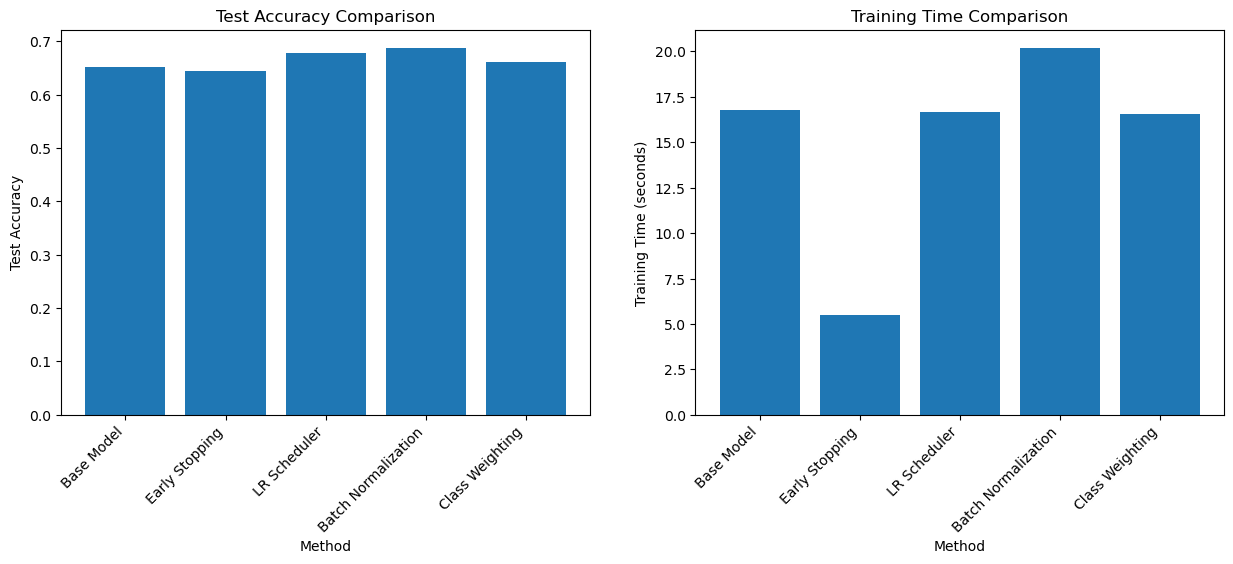

In [45]:

print("COMPARISON OF ALL IMPROVEMENT METHODS")


methods_comparison = pd.DataFrame({
    'Method': ['Base Model', 'Early Stopping', 'LR Scheduler', 'Batch Normalization', 'Class Weighting'],
    'Test Accuracy': [base_test_acc, es_test_acc, sched_test_acc, bn_test_acc, cw_test_acc],
    'Precision': [base_prec, es_prec, sched_prec, bn_prec, cw_prec],
    'Recall': [base_rec, es_rec, sched_rec, bn_rec, cw_rec],
    'F1 Score': [base_f1, es_f1, sched_f1, bn_f1, cw_f1],
    'Training Time (s)': [
        sum(base_history['epoch_time_sec']),
        sum(es_history['epoch_time_sec']),
        sum(sched_history['epoch_time_sec']),
        sum(bn_history['epoch_time_sec']),
        sum(cw_history['epoch_time_sec'])
    ]
})

print(methods_comparison.to_string(index=False))

# Find best method
best_method_idx = methods_comparison['Test Accuracy'].idxmax()
best_method_name = methods_comparison.loc[best_method_idx, 'Method']
best_method_acc = methods_comparison.loc[best_method_idx, 'Test Accuracy']

print(f"\n Best Method: {best_method_name} with accuracy {best_method_acc:.4f}")

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy comparison
axes[0].bar(range(len(methods_comparison)), methods_comparison['Test Accuracy'])
axes[0].set_xlabel('Method')
axes[0].set_ylabel('Test Accuracy')
axes[0].set_title('Test Accuracy Comparison')
axes[0].set_xticks(range(len(methods_comparison)))
axes[0].set_xticklabels(methods_comparison['Method'], rotation=45, ha='right')



# Training time comparison
axes[1].bar(range(len(methods_comparison)), methods_comparison['Training Time (s)'])
axes[1].set_xlabel('Method')
axes[1].set_ylabel('Training Time (seconds)')
axes[1].set_title('Training Time Comparison')
axes[1].set_xticks(range(len(methods_comparison)))
axes[1].set_xticklabels(methods_comparison['Method'], rotation=45, ha='right')


plt.show()



Pretty much all the models increase the accuracy of the model except early stopping, that decreases it by a bit. Batch Normaliztion ends up being the best accuracy out of it all, but at the same time has the highest training time. It depends on the user of the model the balance they want within their model. Early Stopping has the worst performance but takes the least amount of time, so if early stopping meets a threshold someone has for their model accuracy, it might be the best option.

In [46]:
torch.save(model_bn.state_dict(), "a2_part2_weights_JadenPeacock.pkl")

References:
https://www.geeksforgeeks.org/deep-learning/what-is-batch-normalization-in-deep-learning/

https://www.geeksforgeeks.org/machine-learning/regularization-by-early-stopping/

https://docs.pytorch.org/tutorials/recipes/recipes/tuning_guide.html